In [1]:
%reset -f
import ROOT

%run -i ../eppi0_columns.py

#df = ROOT.RDataFrame("h22","../data/lvl2_eppi0.inb.qa.root")
df = ROOT.RDataFrame("h22","../data/lvl2_eppi0.inb.qa.eloss.root")
#df = ROOT.RDataFrame("h22","data/mc.root")

df = define_eppi0_columns_using_proton(df)

%run -i ../eppi0_binning_scheme_v2.py
shards,df  = define_eppi0_bins(df,"inb")

Welcome to JupyROOT 6.24/06


In [2]:
rdf = df.Define("dpp","""
TLorentzVector beam(0,0,10.6041,10.6041), targ(0,0,0,0.938);
TLorentzVector ele, pro;

ele.SetXYZM(ex,ey,ez,0);
pro.SetXYZM(px,py,pz,0.938);

auto xx = beam+targ-ele;

double Mp = 0.938, Mpi0 = 0.13497;

double dot = xx.Vect().Dot(pro.Vect().Unit());
double eX = xx.E(), mX = xx.M();

double det = 4*pow(dot,2)*pow(eX,2)*pow(Mp,2) - 4*pow(eX,4)*pow(Mp,2) + pow(eX,2)*pow(Mp,4) -
       2*pow(eX,2)*pow(Mp,2)*pow(Mpi0,2) + pow(eX,2)*pow(Mpi0,4) + 2*pow(eX,2)*pow(Mp,2)*pow(mX,2) -
       2*pow(eX,2)*pow(Mpi0,2)*pow(mX,2) + pow(eX,2)*pow(mX,4);

if(det<0) return -100.0;

double pp1 = (-(dot*pow(Mp,2)) + dot*pow(Mpi0,2) - dot*pow(mX,2) - sqrt(det))/(2.*(pow(dot,2) - pow(eX,2)));
double pp2 = (-(dot*pow(Mp,2)) + dot*pow(Mpi0,2) - dot*pow(mX,2) + sqrt(det))/(2.*(pow(dot,2) - pow(eX,2)));

return abs(pp1-pp)<abs(pp2-pp) ? pp1-pp : pp2-pp;
""")


rdf = rdf.Define("mm2a","""
TLorentzVector beam(0,0,10.6041,10.6041), targ(0,0,0,0.938);
TLorentzVector ele, pro;

double fp = pp>2 ? (pp+dpp)/pp : 1;
fp = (pp+dpp)/pp;

ele.SetXYZM(ex,ey,ez,0);
pro.SetXYZM(fp*px,fp*py,fp*pz,0.938);

return (beam+targ-ele-pro).M2();
""")

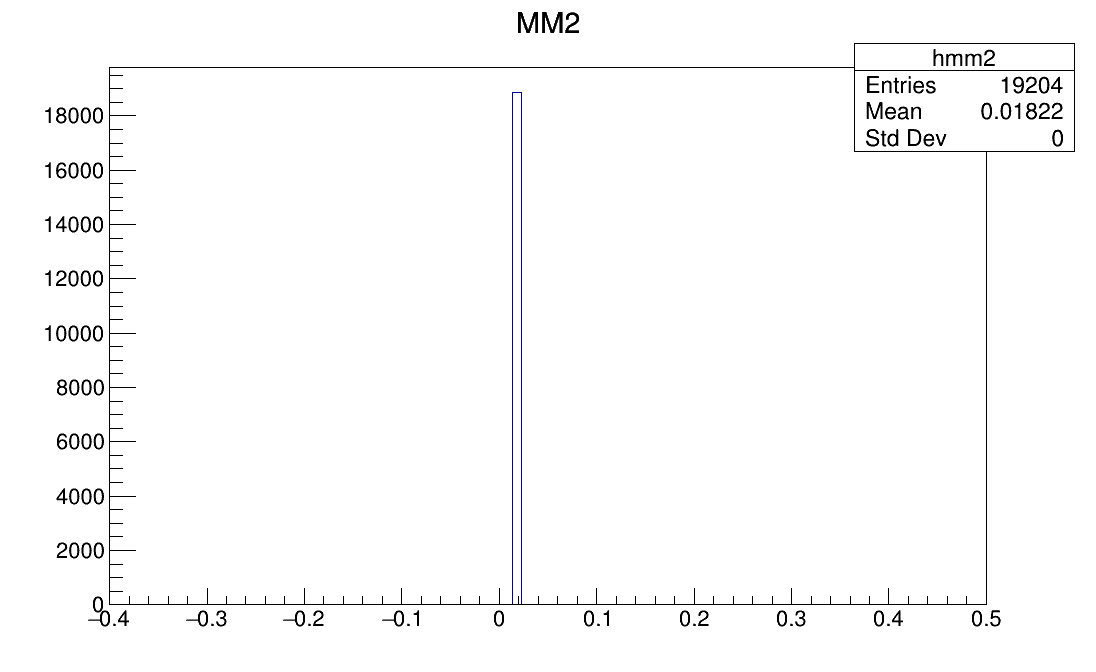

In [3]:
c1 = ROOT.TCanvas("c1","c1",1100,700)
c1.Draw()

hmm2pp = rdf.Histo2D(("hmm2pp","MM2 vs Pp",100,0,3,100,-0.4,0.5), "pp","mm2a")
hmm2pp.Draw("colz")

hmm2 = rdf.Filter("pp>2").Histo1D(("hmm2","MM2",100,-0.4,0.5), "mm2a")
hmm2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


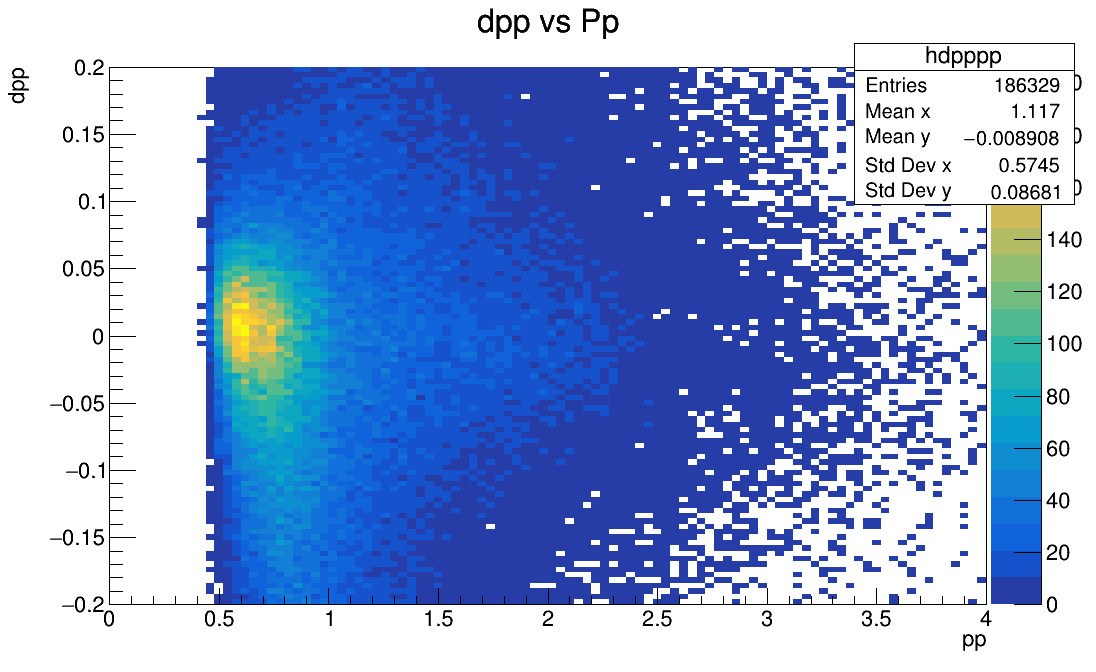

In [4]:
c1 = ROOT.TCanvas("c1","c1",1100,700)
c1.Draw()

hdpppp = rdf.Histo2D(("hdpppp","dpp vs Pp;pp;dpp",100,0,4,100,-0.2,0.2), "pp","dpp")
hdpppp.Draw("colz")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


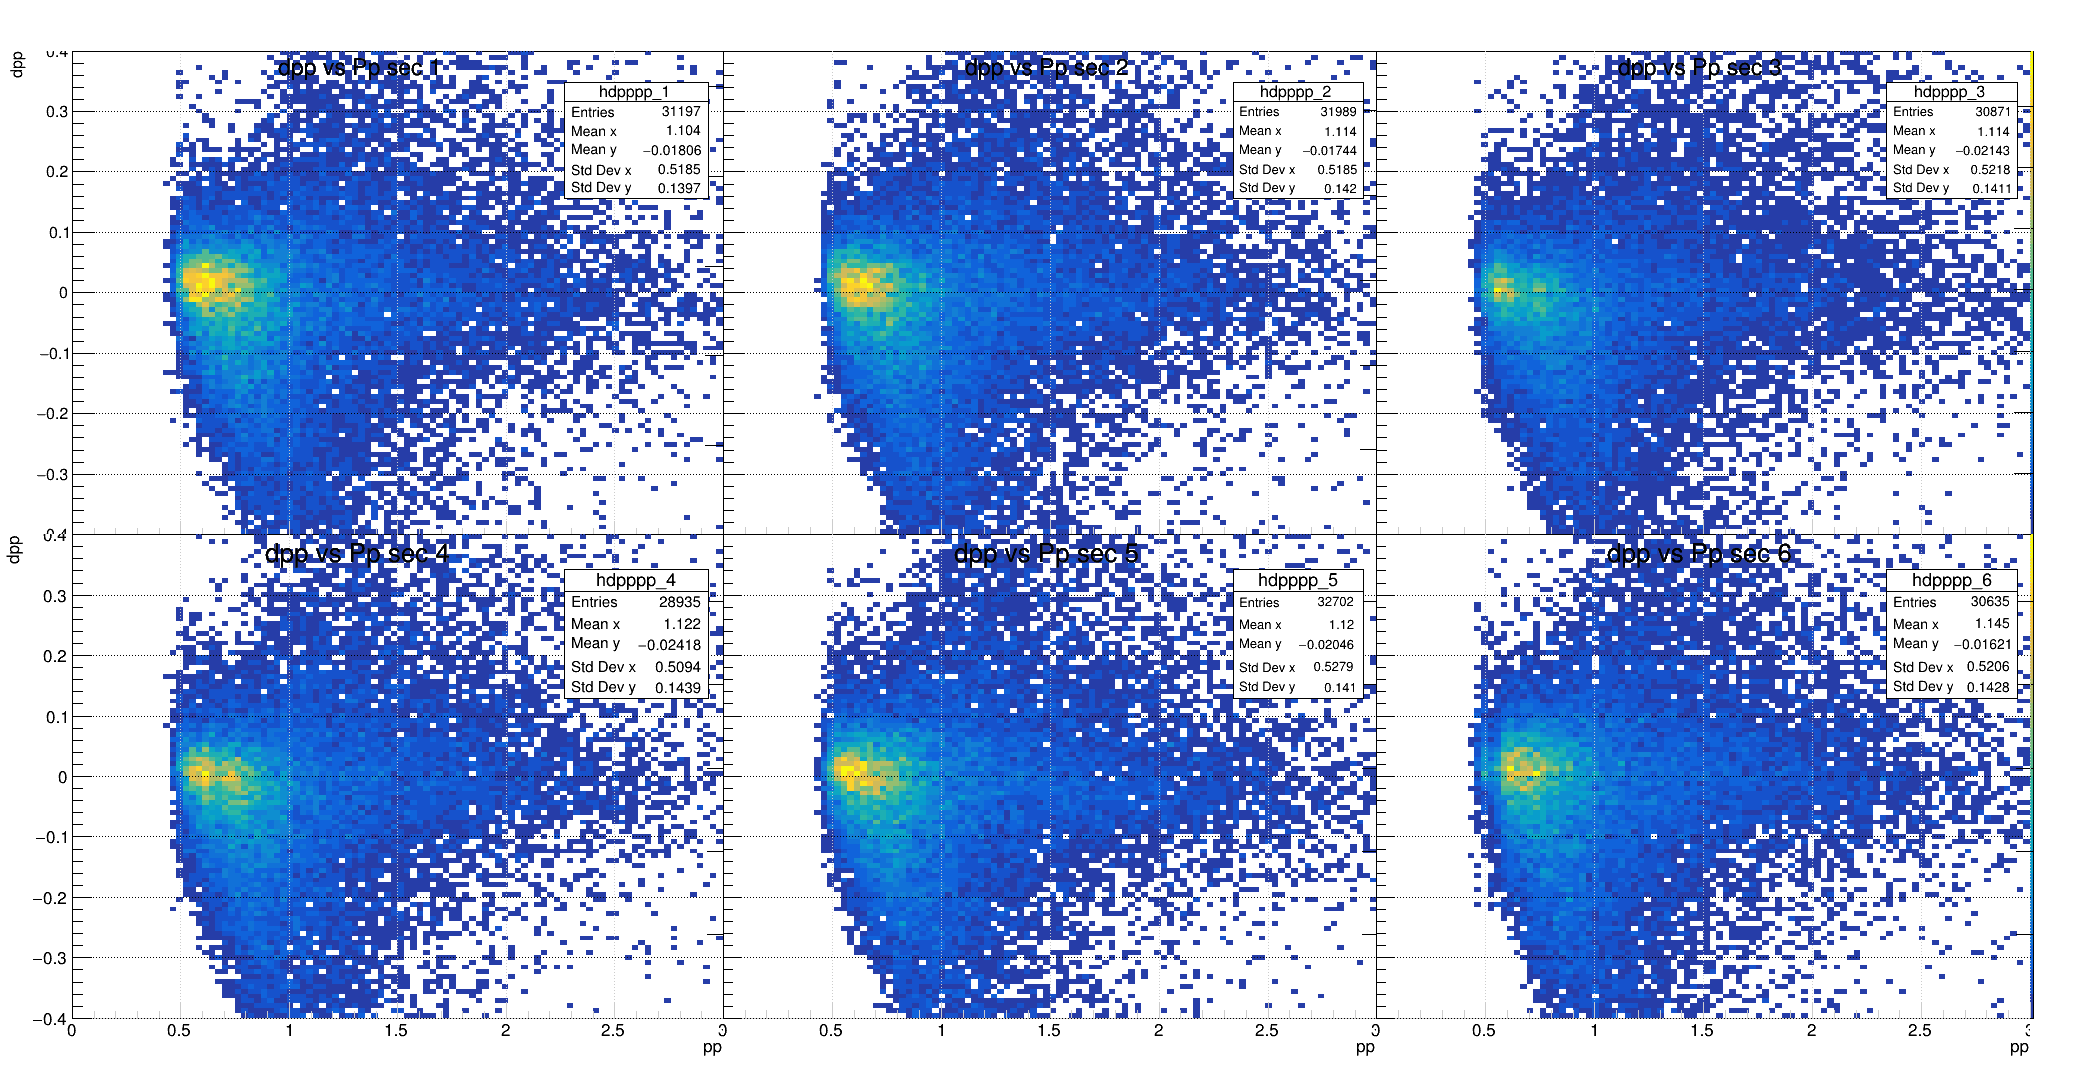

In [8]:
c1 = ROOT.TCanvas("c1","c1",2100,1100)
c1.Draw()
c1.Divide(3,2,0,0)

ROOT.gStyle.SetAxisColor(17)
ROOT.gStyle.SetOptFit(1)

hdpppps = []
pplims = [0.5,0.6,0.75,0.9,1.1,1.3,1.6,2,2.5,3,4]
for psec in range(1,7):
    bdf0 = rdf.Filter(f"psec=={psec}")
    h2 = bdf0.Histo2D((f"hdpppp_{psec}", f"dpp vs Pp sec {psec};pp;dpp",100,0,3,100,-0.4,0.4), "pp", "dpp")
    hdpppps.append(h2)
    axpp = h2.GetXaxis()
    setattr(h2, "pbins", [])
    
    c1.cd(psec).SetGrid(1)
    h2.Draw("colz")

    for pp0,pp1 in zip(pplims[:-1], pplims[1:]):
        bdf1 = bdf0.Filter(f"pp>{pp0} && pp<{pp1}")
        h1 = bdf1.Histo1D((str(("hdpp",psec,pp0,pp1)),str(("hdpp",psec,pp0,pp1)), 100,-0.4,0.4), "dpp")
        ppm = bdf1.Filter("dpp>-100").Mean("pp")
        h2.pbins.append((ppm,h1))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


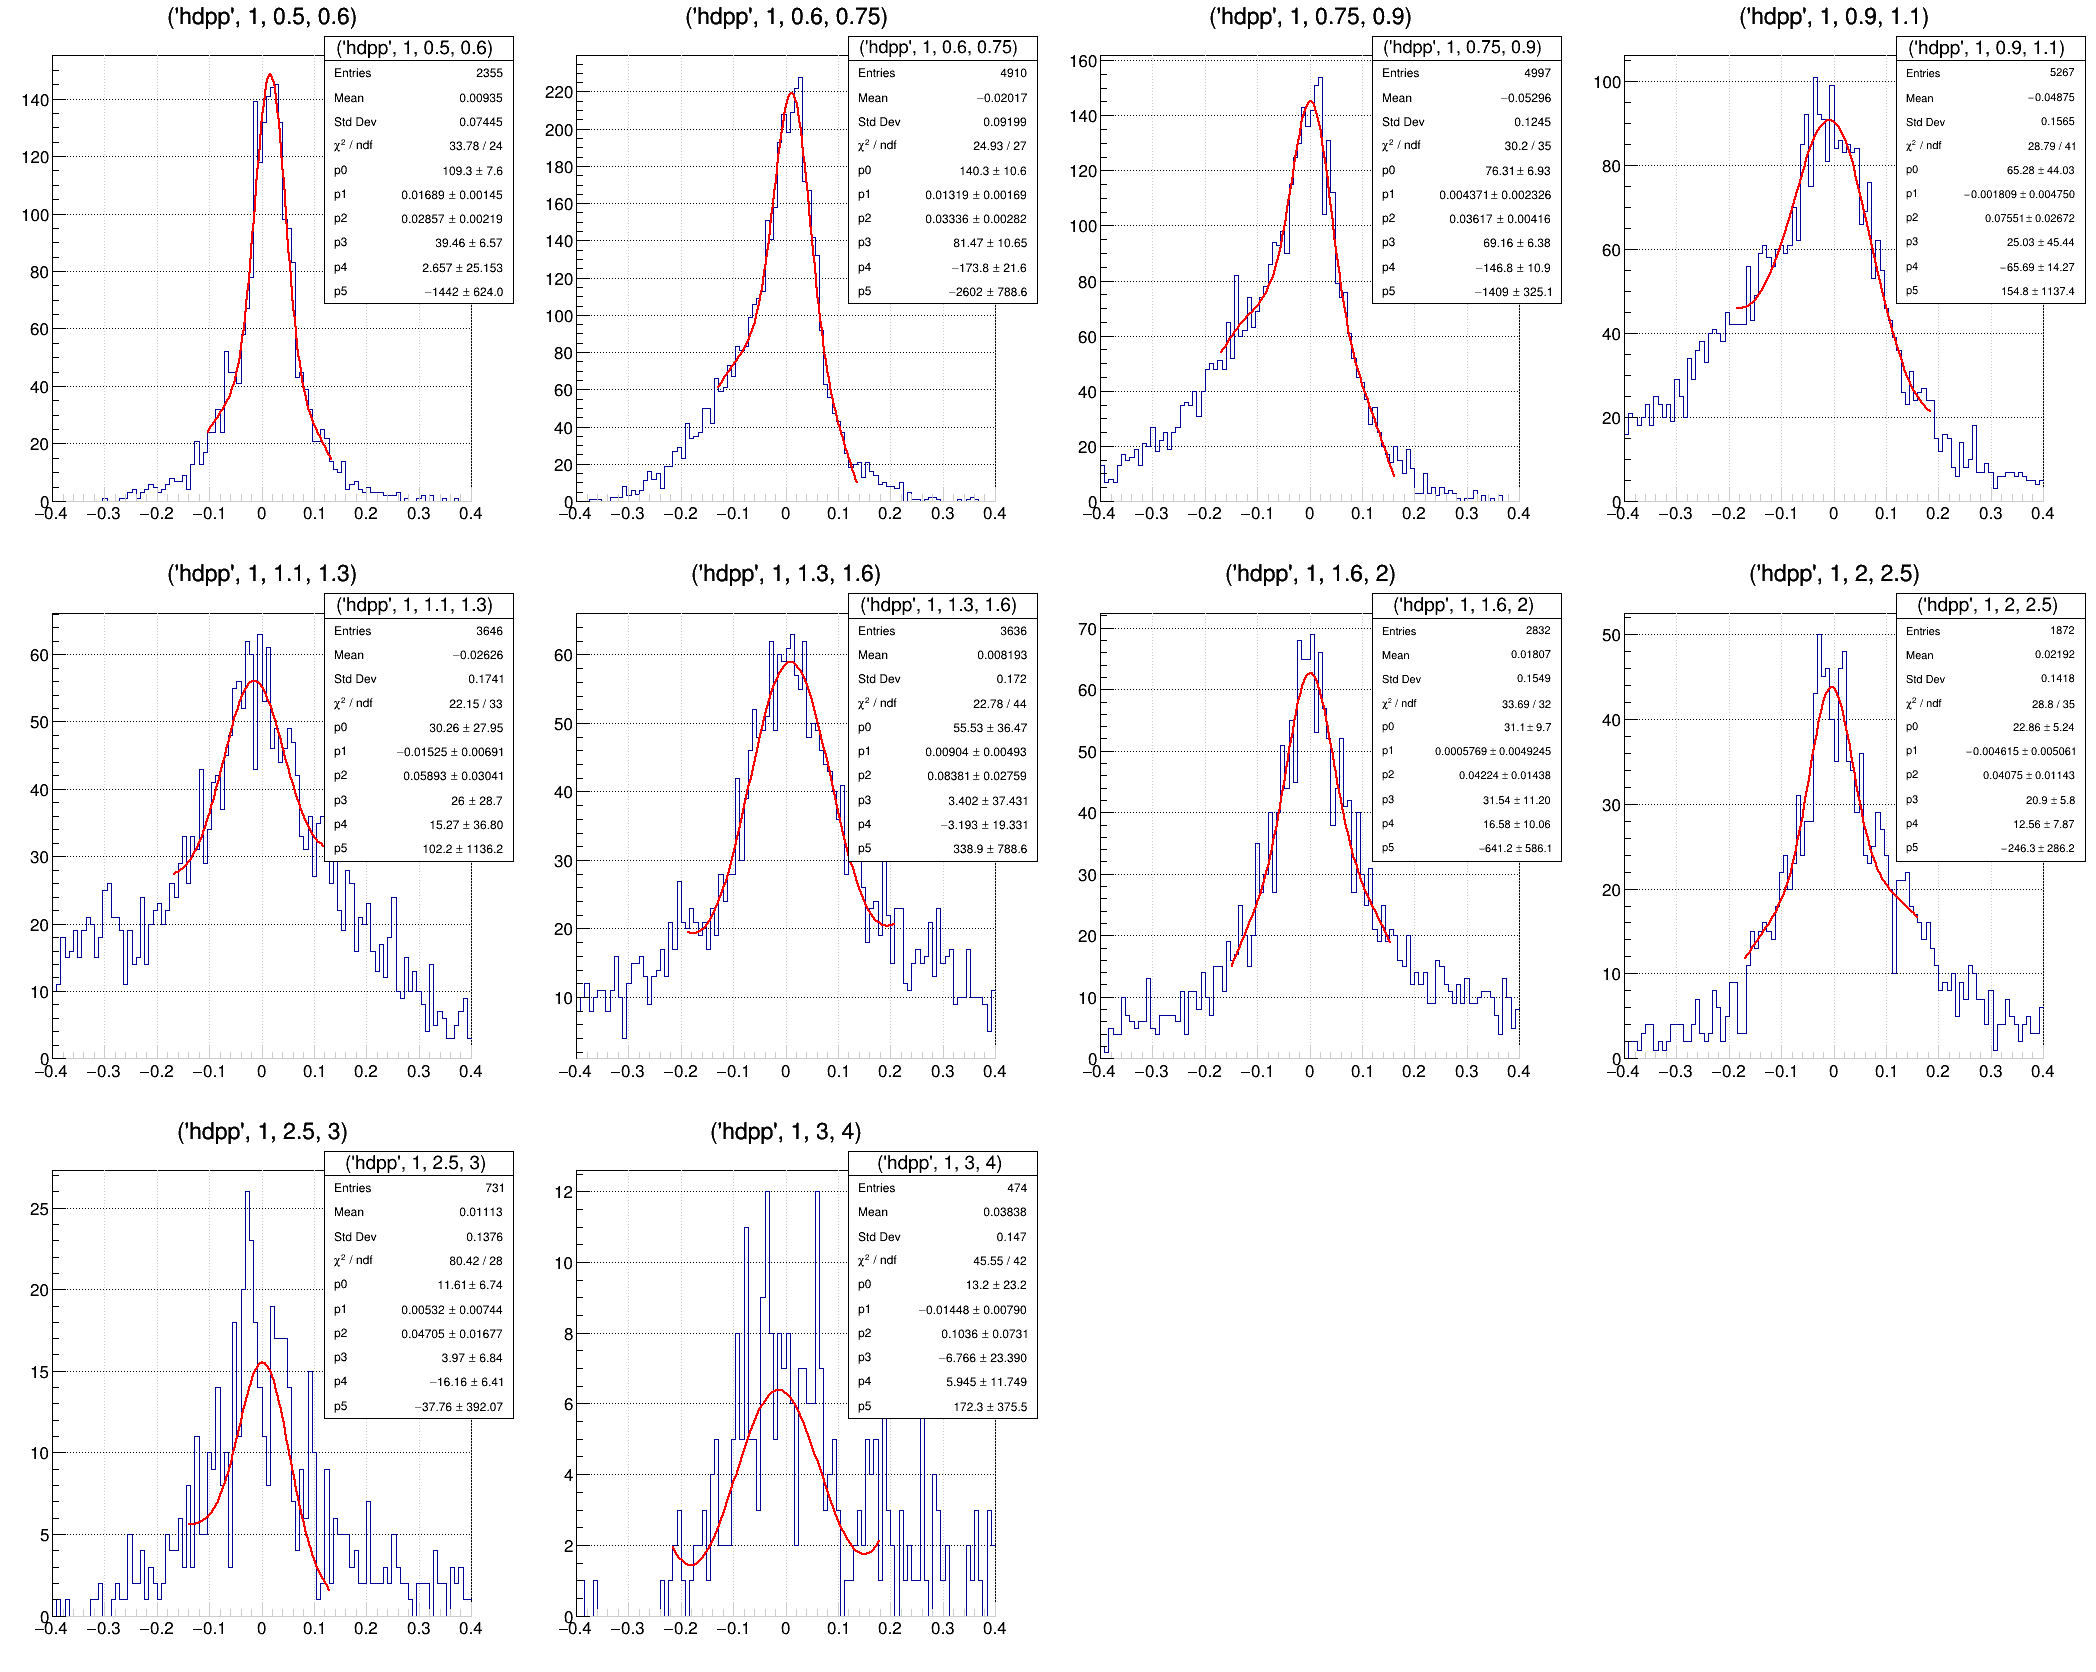

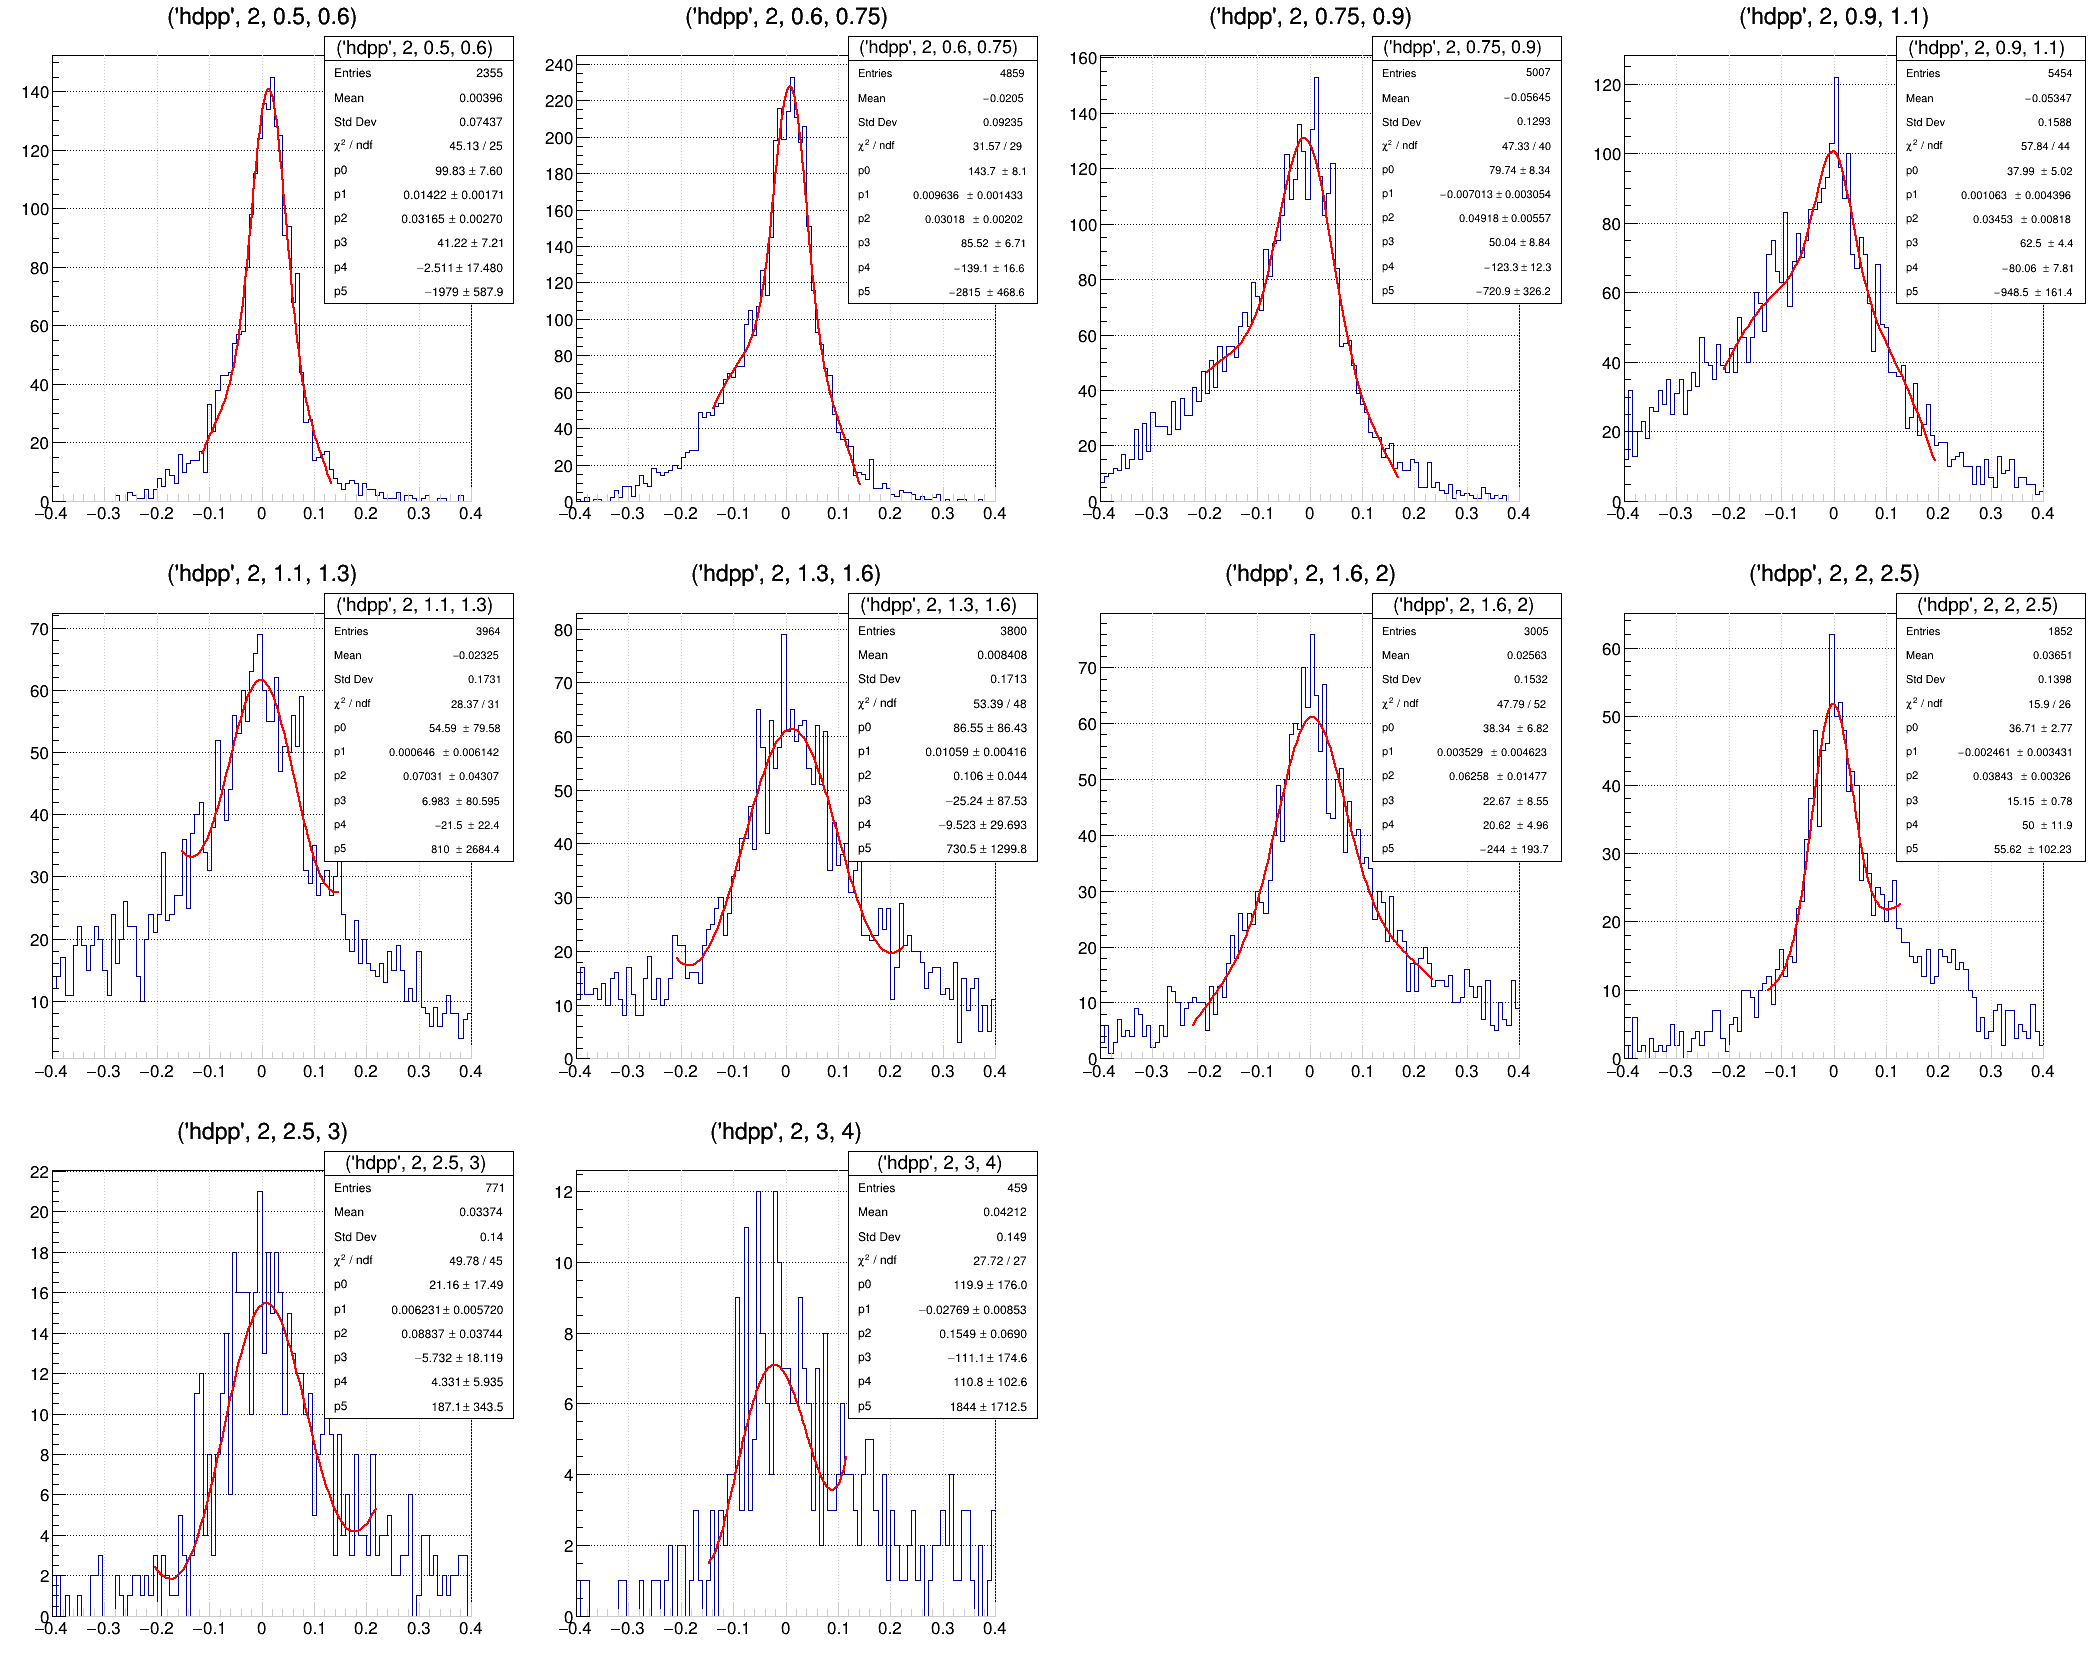

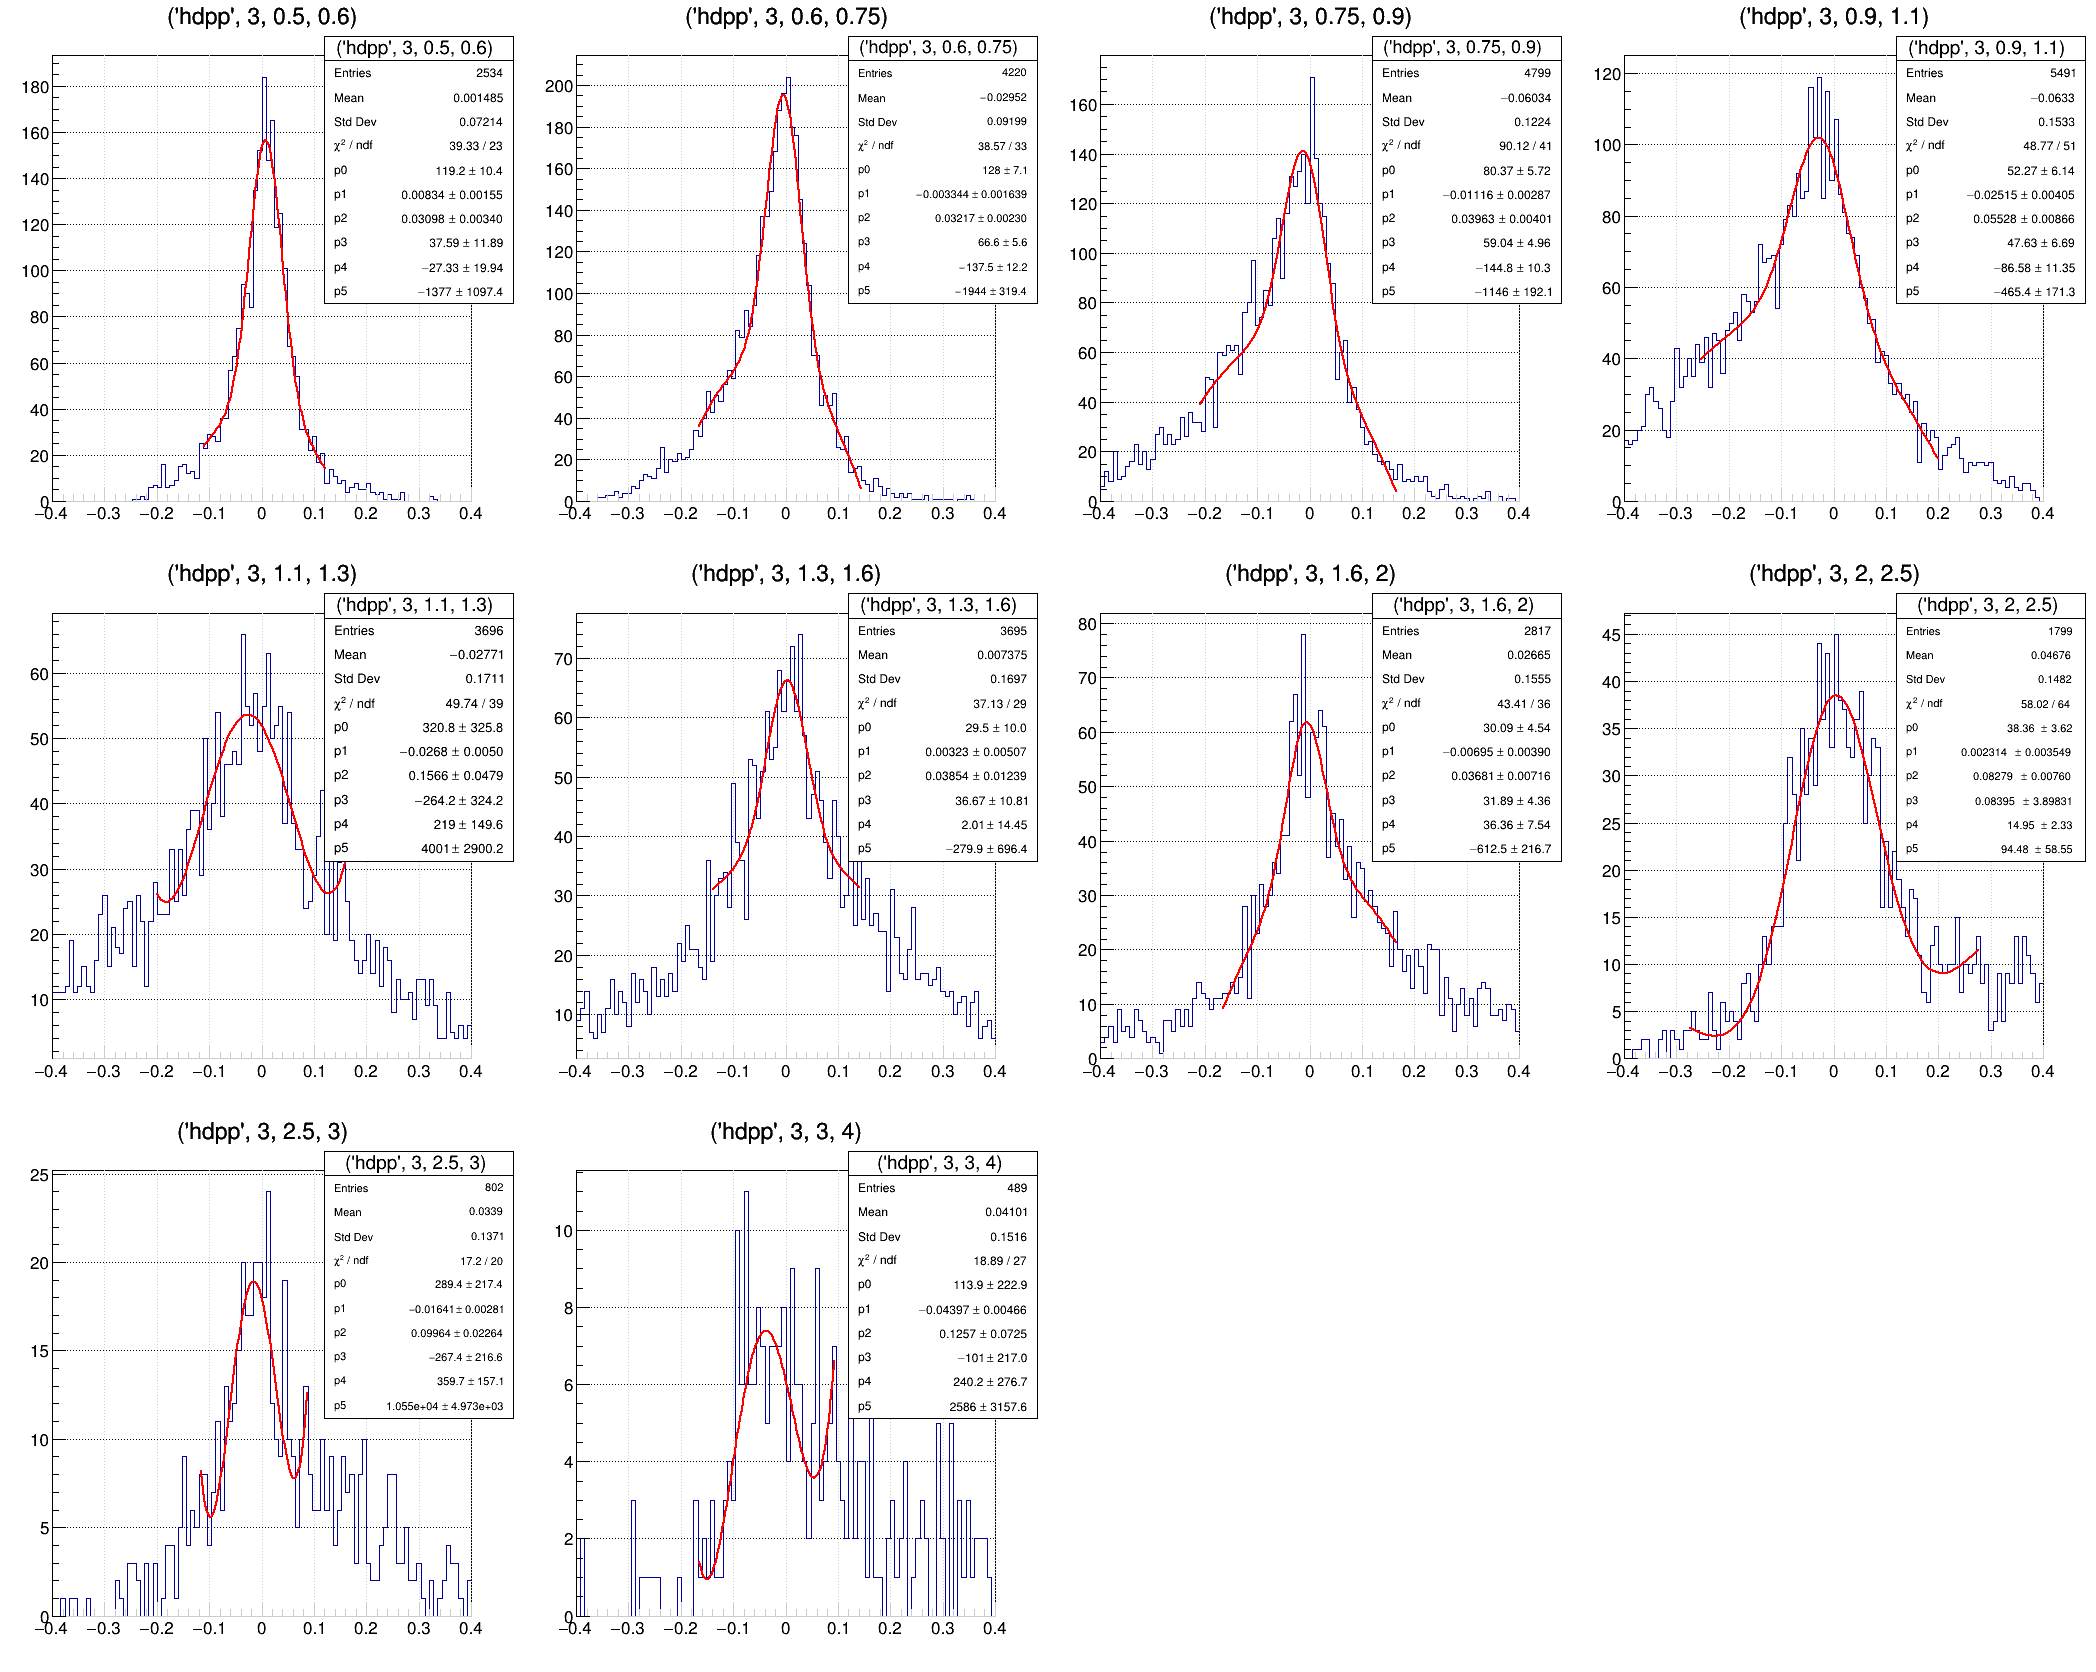

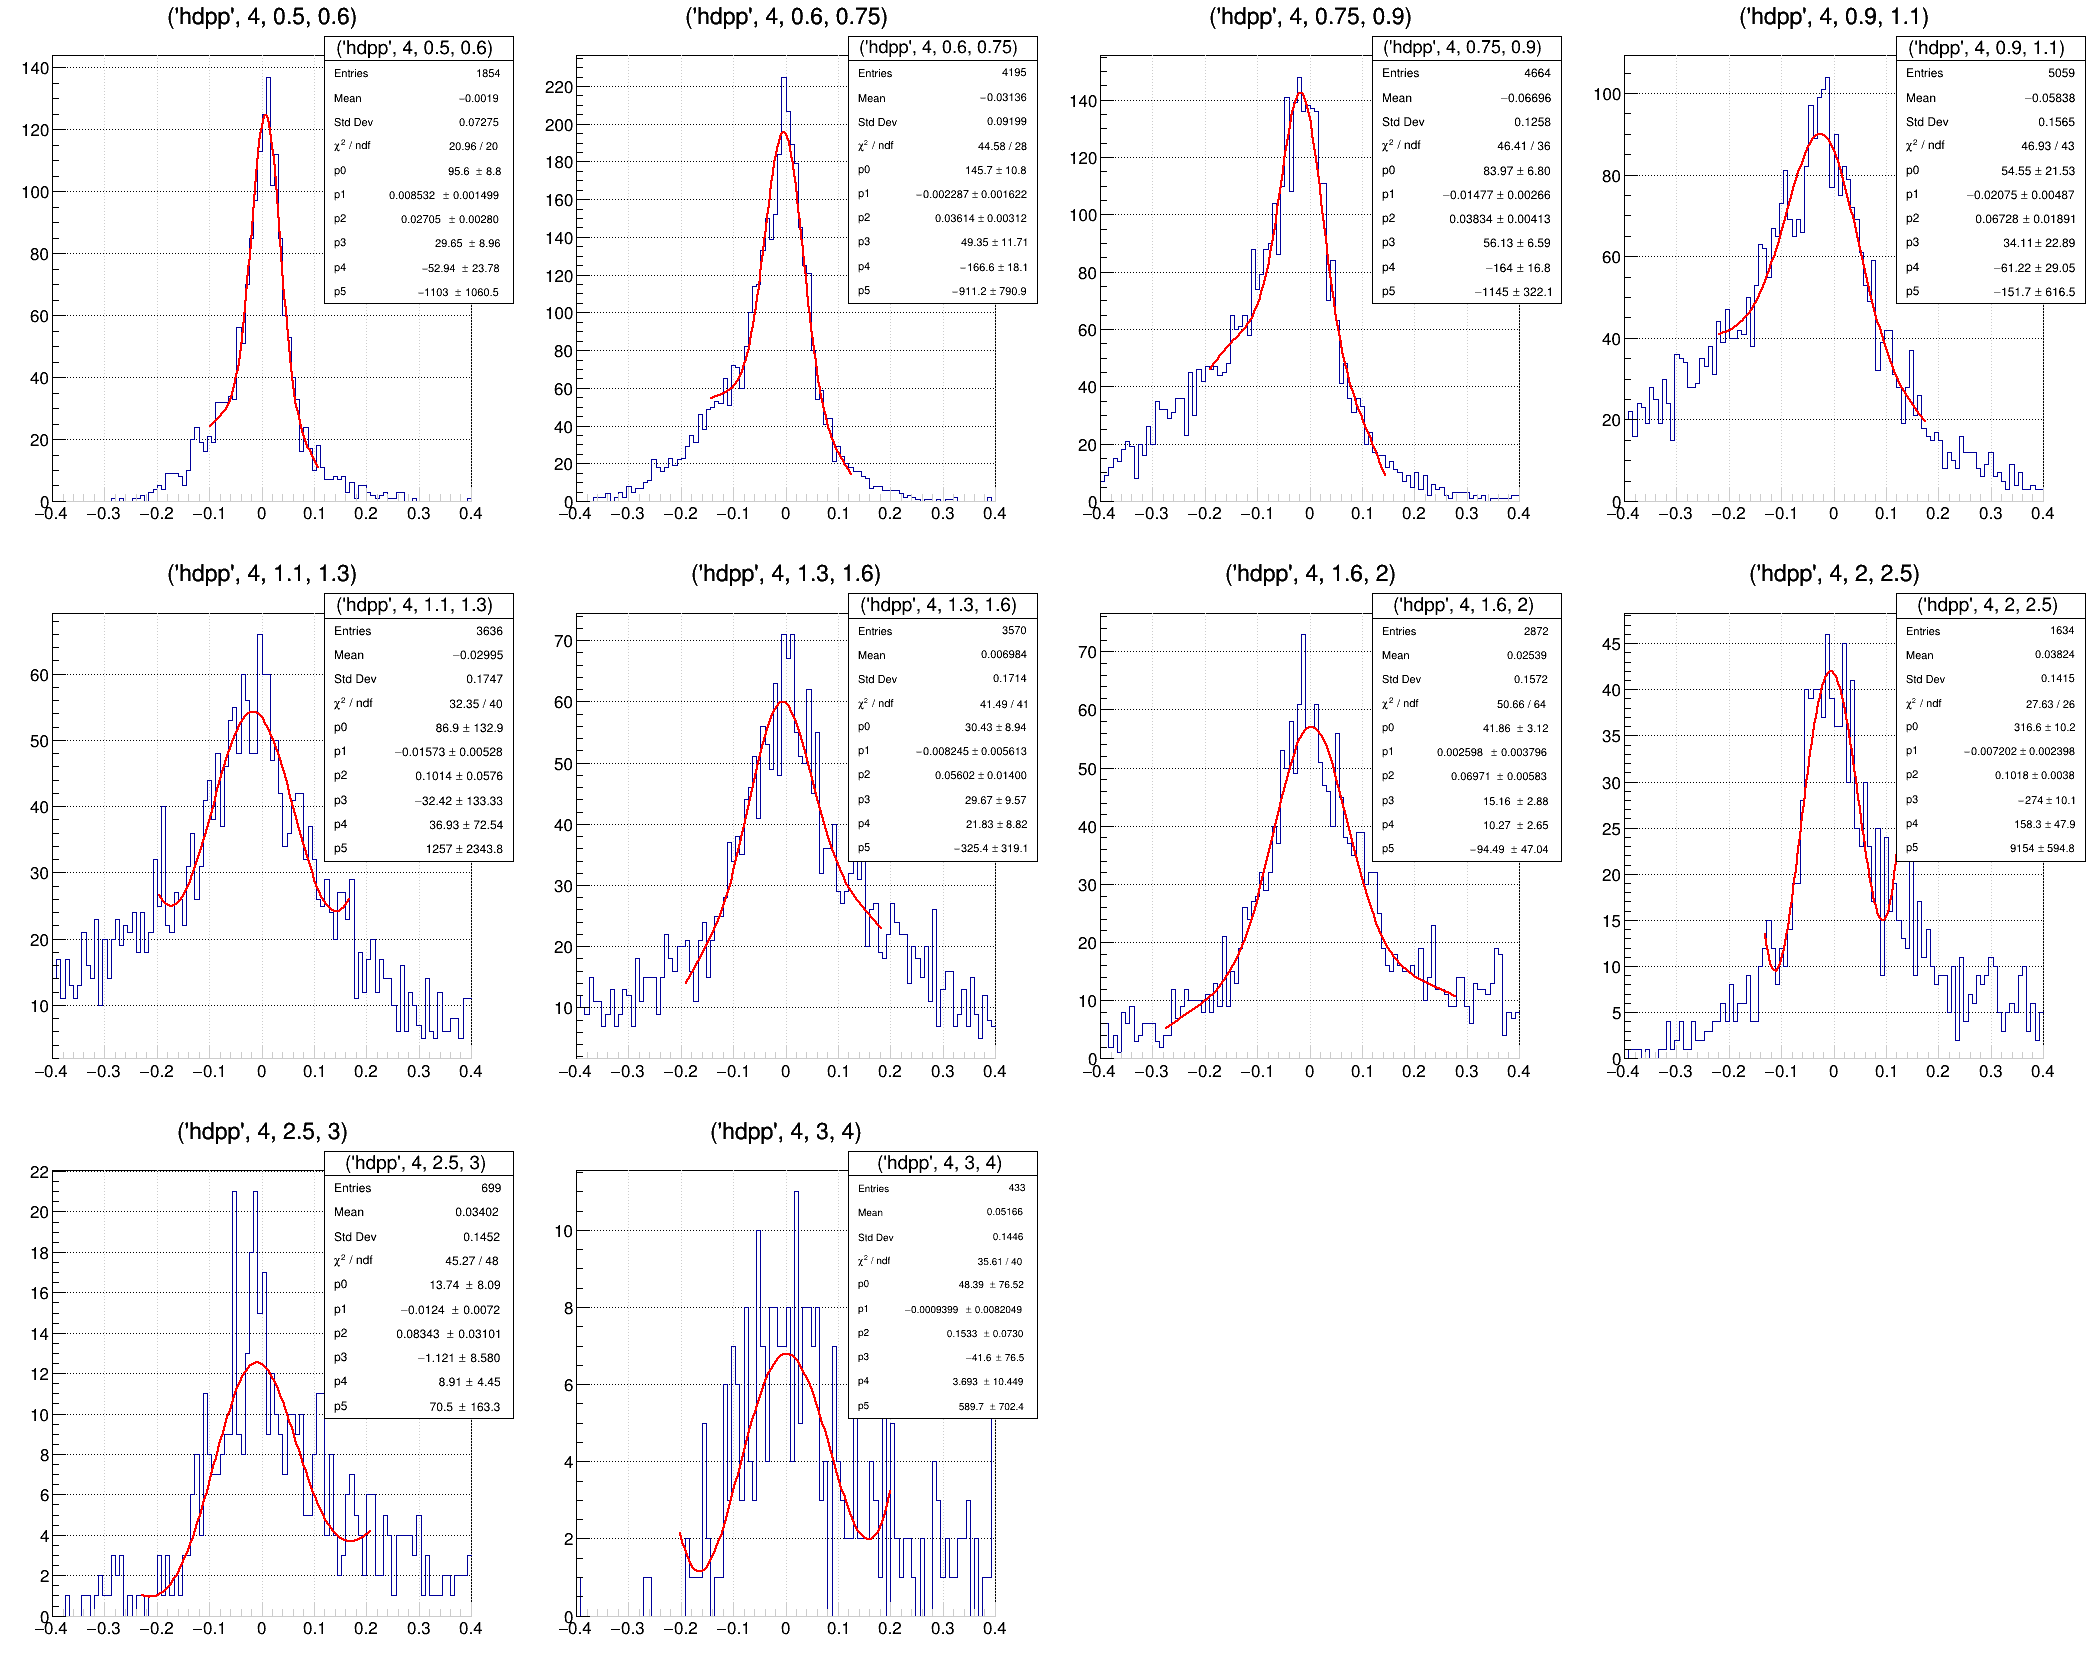

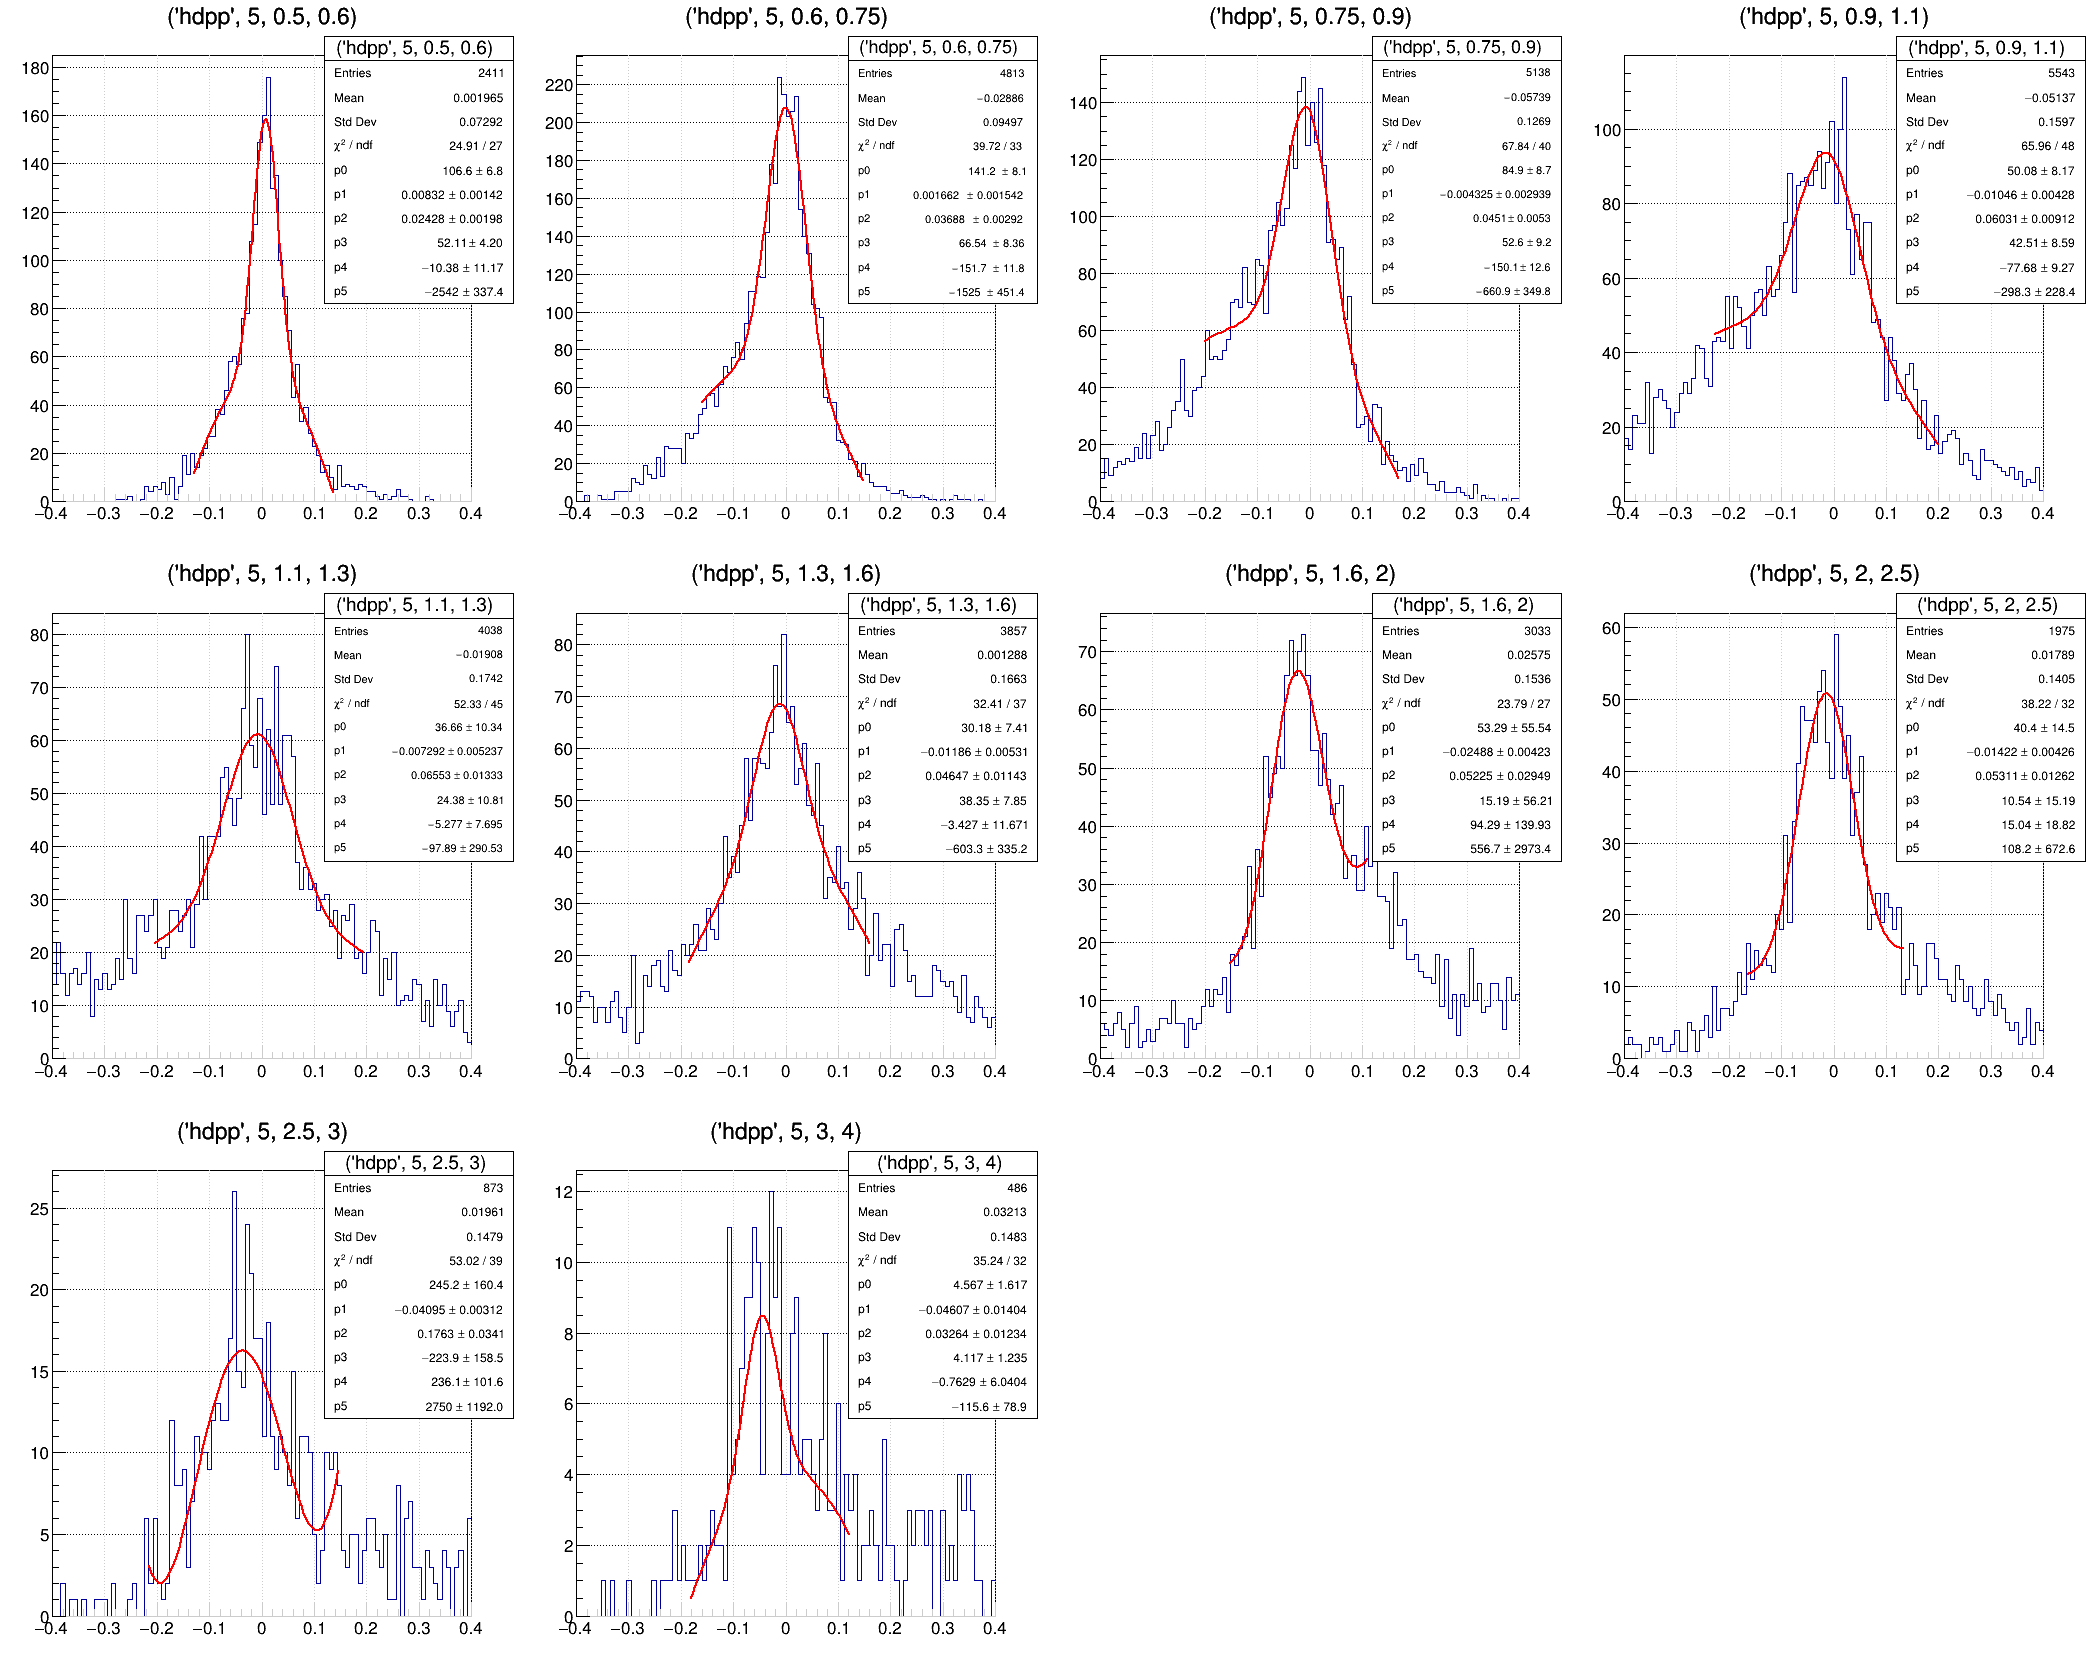

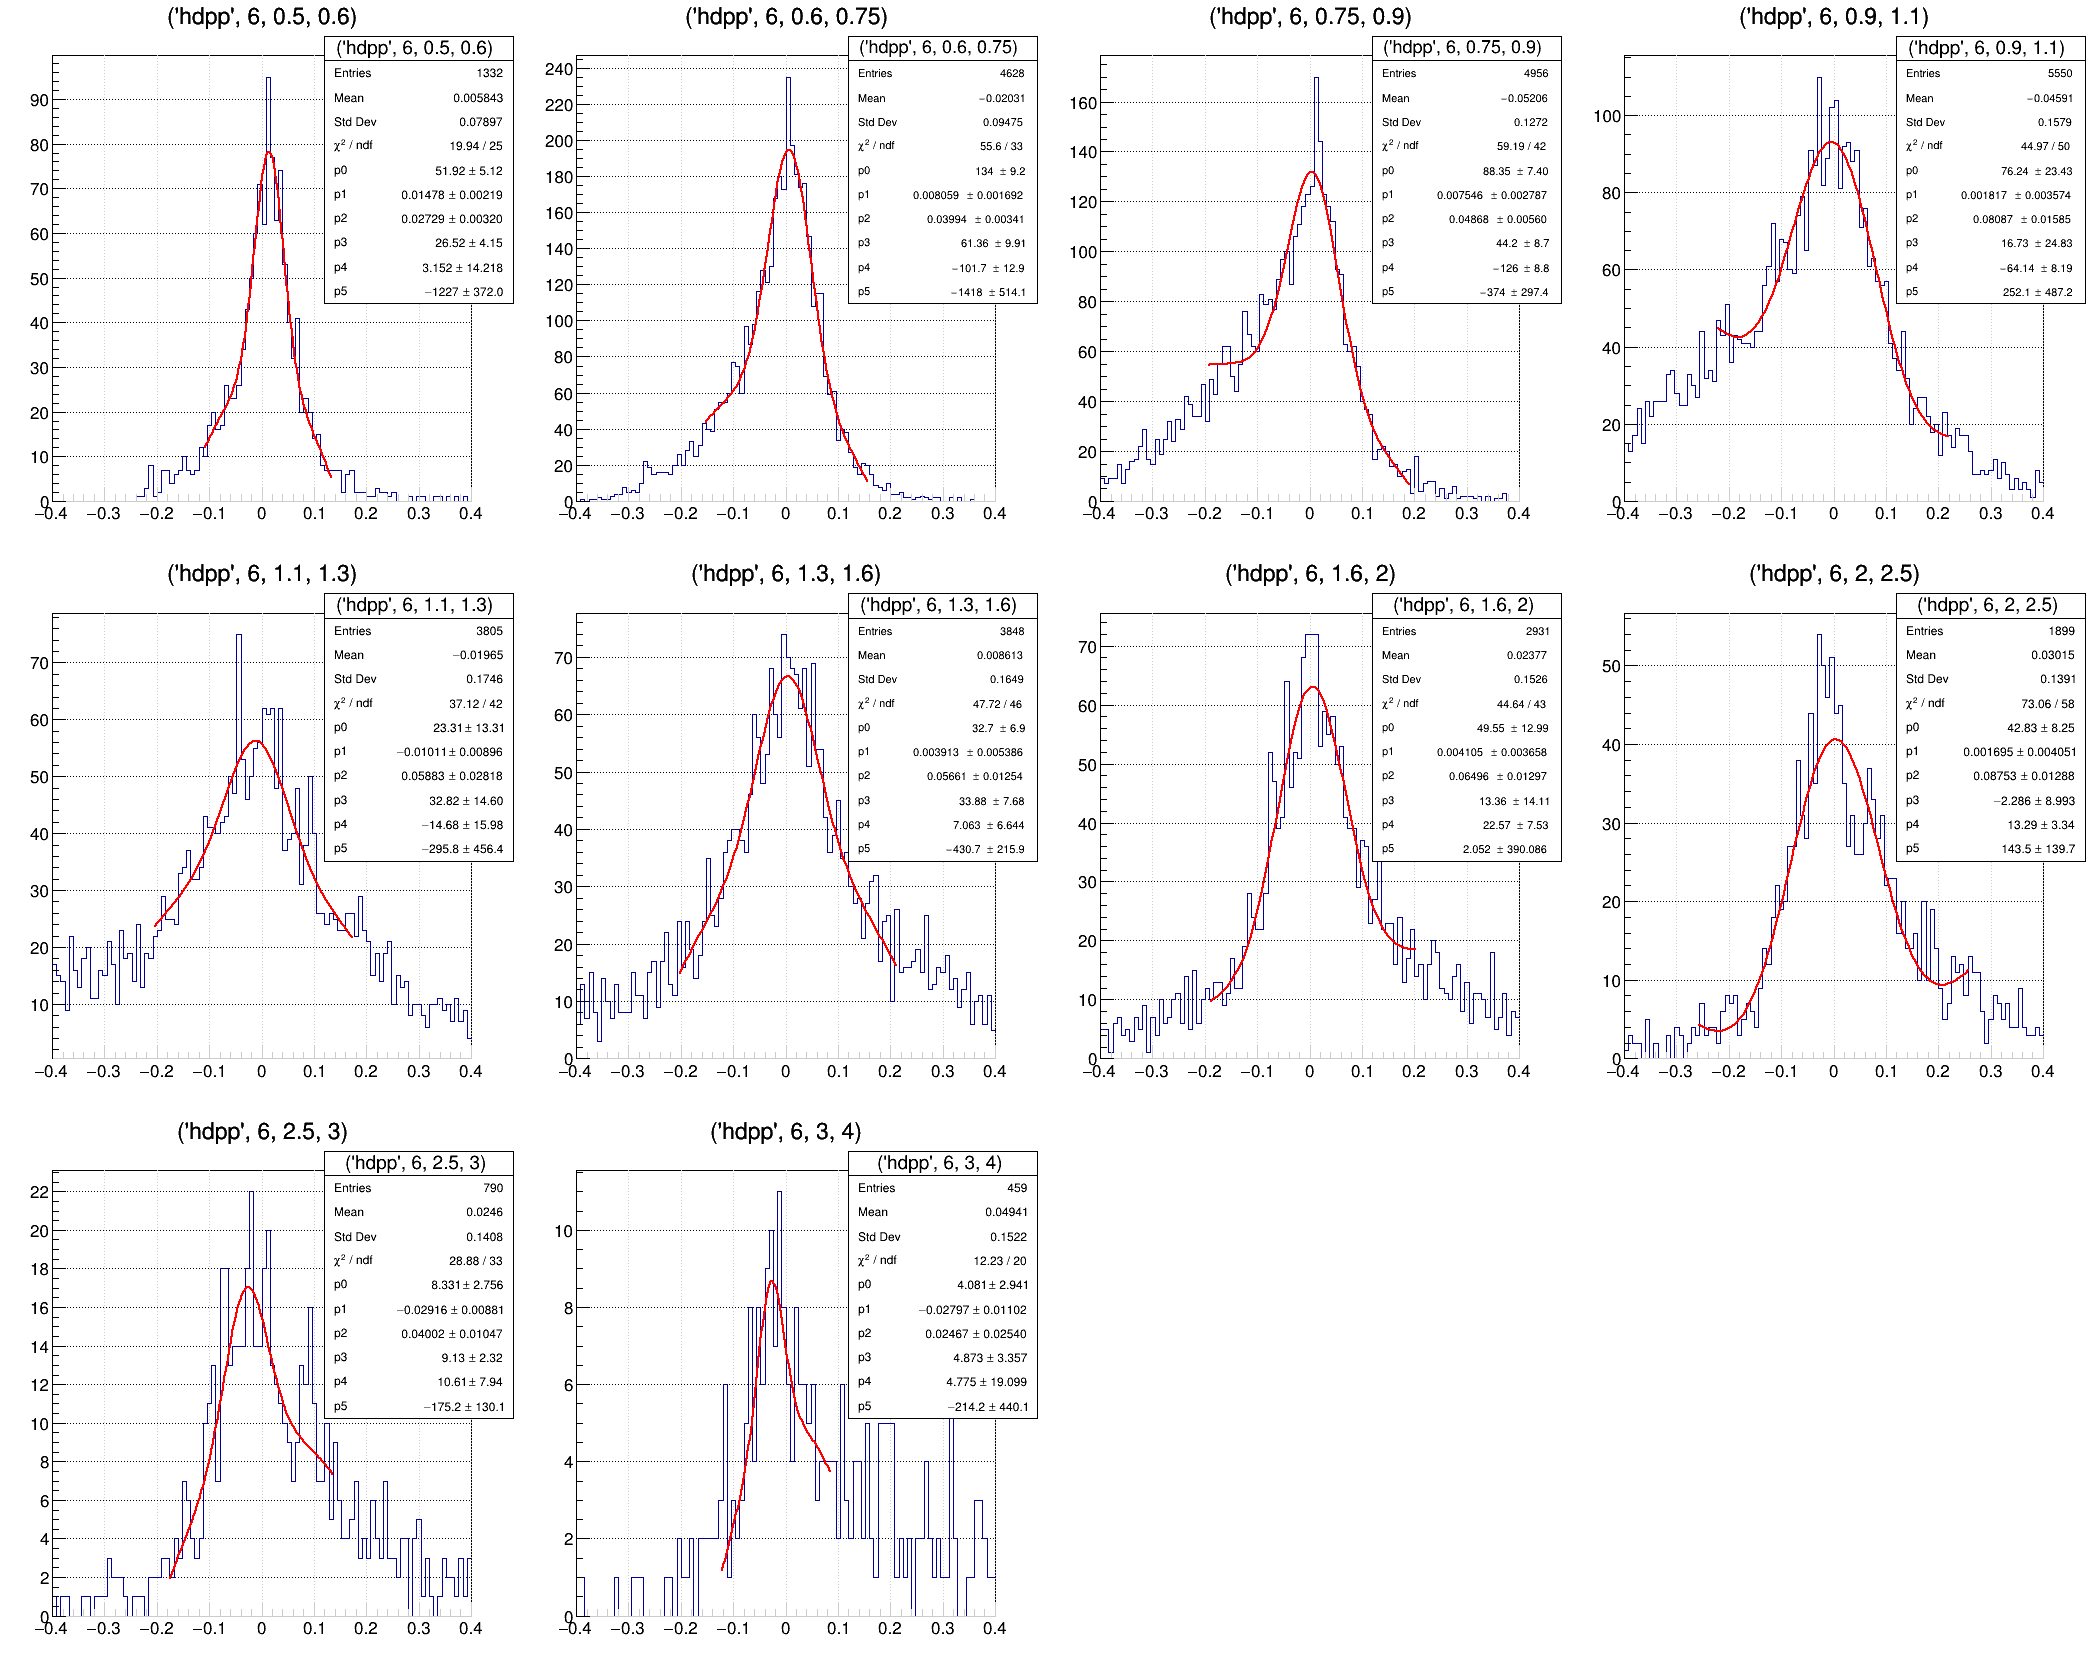

In [9]:
cans=[]
for sec in range(1,7):
    c2 = ROOT.TCanvas(f"c{sec}",f"c{sec}",2100,1700)
    c2.Draw(); cans.append(c2)
    c2.Divide(4,3,0.0001,0.0001)

    ipad=0
    h2 = hdpppps[sec-1]
    gr = ROOT.TGraphErrors()
    setattr(h2, 'gr', gr)
    for ppm,h1 in h2.pbins:
        ipad+=1
        c2.cd(ipad).SetGrid()
        f1 = ROOT.TF1("f1."+h1.GetName(), "gaus(0)+pol2(3)",-0.24,0.24)
        f1.SetParameters(1,0,0.1,1,1)
        h1.Fit(f1,"QR")
        mu,sig = f1.GetParameter(1),f1.GetParameter(2)
        f1.SetRange(mu-3*sig, mu+3*sig)
        h1.Fit(f1,"QR")
        h1.Draw()

        gr.SetPoint(gr.GetN(), ppm.GetValue(), f1.GetParameter(1))
        gr.SetPointError(gr.GetN()-1, 0, f1.GetParError(1))


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


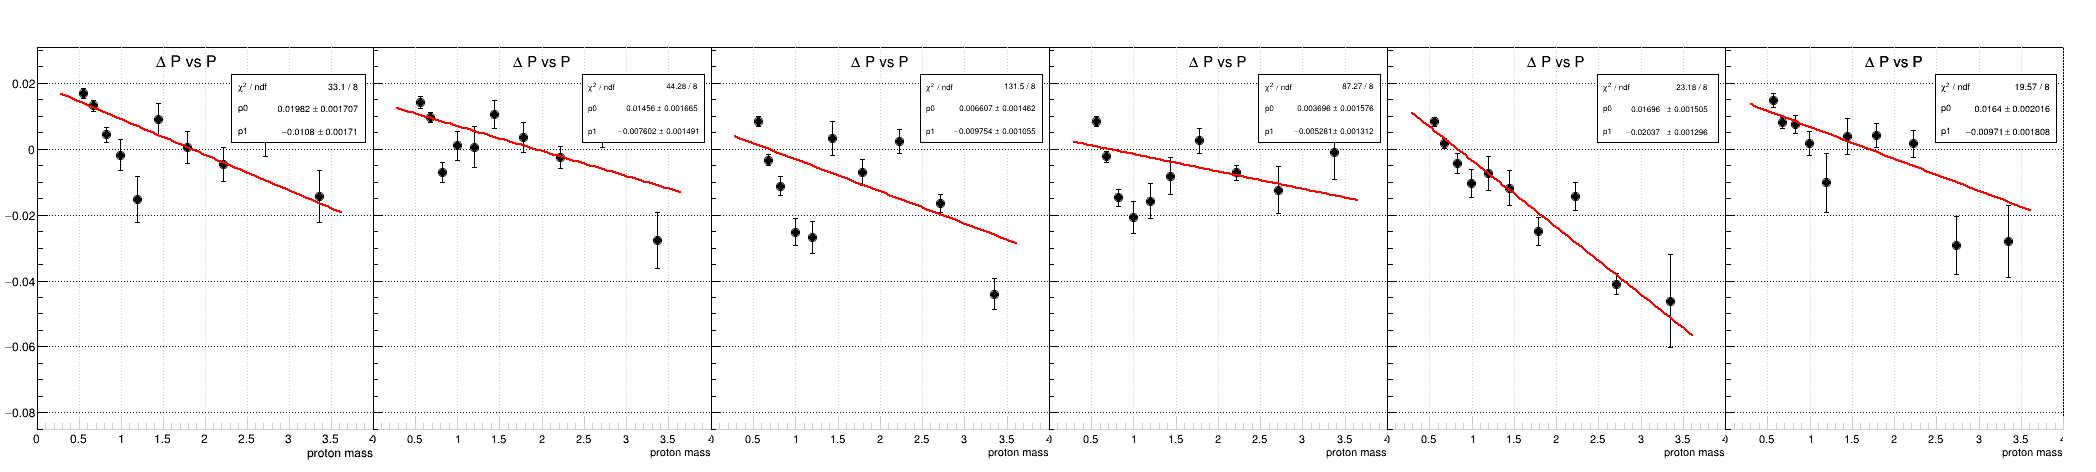

In [29]:
c1 = ROOT.TCanvas("c1","c1",2100,500)
c1.Draw()
c1.Divide(6,1,0,0)

for sec in range(1,7):
    c1.cd(sec).DrawFrame(0,-0.0851,4,0.031).SetTitle("#Delta P vs P;proton mass")
    c1.cd(sec).SetGrid()
    
    h2 = hdpppps[sec-1]
    gr = h2.gr
    gr.Draw("P")
    gr.SetMarkerStyle(20)
    f1 = ROOT.TF1("f1."+str(id(gr)),"pol1",0,4)
    gr.Fit(f1,'q')
    p0,p1 = f1.GetParameter(0), f1.GetParameter(1)
    #print(f"dpp={p0}+{p1}*pp;")
